# tensorflow: Training Neural Networks for Classification and Dimensionality Reduction

This notebook demonstrates example neural network setups for **image classification** and **dimensionality reduction** tasks using `tensorflow`.

The examples serve as complement and comparison for exploring neural networks with the `edu.yaprnn` app.

### TensorFlow on Windows: Virtual Environment Setup

To ensure TensorFlow compatibility on Windows, use the script `setup-venv-tensorflow-2.10.1.sh` to create a dedicated Python virtual environment with TensorFlow version `2.10.1`.

Loading MNIST images from E:\edu.yaprnn\src\main\resources\digits.idx3-ubyte


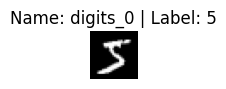

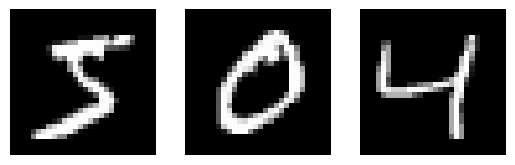

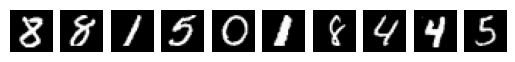

(36000, 784) (36000, 10) (36000,) (12000, 784) (12000, 10) (12000,)
(48000, 784) (48000, 10) (48000,) (12000, 784) (12000, 10) (12000,)
(48000, 784) (48000, 10) (48000,) (12000, 784) (12000, 10) (12000,)


In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

import mnist_utils

mnist_images, image_size, X, random_x_indices, random_feature_indices, y, labels = mnist_utils.from_mnist_images()

digits_train_32k_test_12k = train_test_split(X, y, labels, train_size=0.6, test_size=0.2, random_state=42)
digits_images_from_labels = train_test_split(X, y, labels, train_size=0.8, test_size=0.2, random_state=42)
digits_input_reconstruction = train_test_split(X, y, labels, train_size=0.8, test_size=0.2, random_state=42)

mnist_utils.from_dataset(digits_train_32k_test_12k, explain=True)
mnist_utils.from_dataset(digits_images_from_labels, explain=True)
mnist_utils.from_dataset(digits_input_reconstruction, explain=True)

None

# Digits Classification

This model is configured as follows:

- **Architecture**:
  - Input layer: 784 neurons
  - 2 hidden layers:
    - Layer 1: 20 neurons
    - Layer 2: 15 neurons
  - Output layer: 10 neurons
  - Total parameters: `((784 + 1) * 20) + ((20 + 1) * 15) + ((15 + 1) * 10) = 16175` (Biases included)
- **Activation Function**: Gaussian Error Linear Unit (GeLU)
- **Optimizer**: Stochastic Gradient Descent (SGD)
  - Learning rate: 0.02 (needs adaption to batch size to not overshoot gradient updates)
  - Momentum: 0.2 with Nesterov term
  - L1-weight-decay: 0.0001
  - L2-weight-decay: 0.001
- **Loss Function**: Mean Squared Error (MSE)

In [2]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import L1L2

input_size, output_size, X_train, y_train, X_test, y_test = mnist_utils.from_dataset(digits_train_32k_test_12k)

batch_size = 31
optimizer = SGD(learning_rate=0.02 / batch_size, momentum=0.2, nesterov=True)
loss = 'mse'
regularizer=L1L2(l1=0.0001, l2=0.001)

model = tf.keras.Sequential()
model.add(Dense(20, activation='gelu', input_shape=(input_size,), kernel_regularizer=regularizer))
model.add(Dense(15, activation='gelu', kernel_regularizer=regularizer))
model.add(Dense(output_size, activation='gelu', kernel_regularizer=regularizer))
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=batch_size)

print(f'Actual number of parameters: {model.count_params()}')

Epoch 1/50
1162/1162 [==============================] - 1s 776us/step - loss: 0.2534 - accuracy: 0.1013 - val_loss: 0.2488 - val_accuracy: 0.1141
Epoch 2/50
1162/1162 [==============================] - 1s 647us/step - loss: 0.2459 - accuracy: 0.1261 - val_loss: 0.2436 - val_accuracy: 0.1352
Epoch 3/50
1162/1162 [==============================] - 1s 658us/step - loss: 0.2417 - accuracy: 0.1482 - val_loss: 0.2401 - val_accuracy: 0.1570
Epoch 4/50
1162/1162 [==============================] - 1s 651us/step - loss: 0.2386 - accuracy: 0.1713 - val_loss: 0.2372 - val_accuracy: 0.1792
Epoch 5/50
1162/1162 [==============================] - 1s 647us/step - loss: 0.2358 - accuracy: 0.1961 - val_loss: 0.2346 - val_accuracy: 0.2033
Epoch 6/50
1162/1162 [==============================] - 1s 656us/step - loss: 0.2333 - accuracy: 0.2216 - val_loss: 0.2322 - val_accuracy: 0.2287
Epoch 7/50
1162/1162 [==============================] - 1s 675us/step - loss: 0.2309 - accuracy: 0.2481 - val_loss: 0.2299 -

In [3]:
import numpy as np

model.evaluate(X_train, y_train)
model.evaluate(X_test, y_test)

random_test_indices = np.random.choice(X_test.shape[0], 5, replace=False)
predicted = model.predict(X_test[random_test_indices])
print(np.argmax(predicted, axis=1))
predicted.round(2).astype('str')

1/1 [==============================] - 0s 45ms/step
[6 4 2 9 7]


array([['-0.08', '0.14', '0.28', '-0.0', '0.2', '0.05', '0.33', '-0.04',
        '-0.0', '-0.02'],
       ['-0.07', '-0.1', '-0.06', '-0.03', '0.76', '0.11', '0.06',
        '0.06', '-0.02', '0.17'],
       ['-0.09', '0.08', '0.26', '0.0', '0.14', '0.01', '0.19', '0.1',
        '0.05', '0.07'],
       ['0.11', '-0.0', '0.01', '-0.1', '0.07', '-0.01', '-0.08', '0.32',
        '0.17', '0.36'],
       ['0.02', '-0.07', '-0.0', '0.05', '0.17', '0.17', '0.12', '0.22',
        '0.1', '0.13']], dtype='<U32')

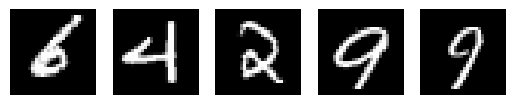

[6 4 2 9 9]


array([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [4]:
mnist_utils.plot_images(X_test[random_test_indices], image_size=image_size, cmap='gray')
print(np.argmax(y_test[random_test_indices], axis=1))
y_test[random_test_indices]

## Dimensionality Reduction with an Autoencoder

This section demonstrates the use of two neural networks for dimensionality reduction. These networks rely on a bottleneck layer in their architecture to reduce the input data's dimensionality.

Instead of using predefined methods to extract the most relevant features, the networks are trained using backpropagation. This approach enables the model to automatically learn a transformation into a compressed feature space along with its inverse transformation to reconstruct the input data as accurately as possible.

### Shallow Autoencoder Network with 12 Neurons Bottleneck Layer

This model is configured as follows:

- **Architecture**:
  - Input layer: 784 neurons
  - 5 hidden layers:
    - Layer 1: 196 neurons
    - Layer 2: 49 neurons
    - Layer 3: 12 neurons
    - Layer 4: 49 neurons
    - Layer 5: 196 neurons
  - Output layer: 784 neurons
  - Total parameters: 328998 (Biases included)
- **Activation Function**: Gaussian Error Linear Unit (GeLU)
- **Optimizer**: Stochastic Gradient Descent (SGD)
  - Learning rate: 0.02
  - Momentum: 0.2 with Nesterov term
  - L1-weight-decay: 0.001
  - L2-weight-decay: 0.001
- **Loss Function**: Mean Squared Error (MSE)

In [5]:
input_size, _, X_train, _, X_test, _ = mnist_utils.from_dataset(digits_input_reconstruction)

batch_size = 31
optimizer = SGD(learning_rate=0.02 / batch_size, momentum=0.2, nesterov=True)
loss = 'mse'
regularizer=L1L2(l1=0.0001, l2=0.001)


def ssim_metric(y_true, y_pred):
    y_true_reshaped = tf.reshape(y_true, [-1, image_size[0], image_size[1], 1])
    y_pred_reshaped = tf.reshape(y_pred, [-1, image_size[0], image_size[1], 1])
    return tf.reduce_mean(tf.image.ssim(y_true_reshaped, y_pred_reshaped, max_val=1.0))


model = tf.keras.Sequential()
model.add(Dense(196, activation='gelu', input_shape=(input_size,), kernel_regularizer=regularizer))
model.add(Dense(49, activation='gelu', kernel_regularizer=regularizer))
model.add(Dense(12, activation='gelu', kernel_regularizer=regularizer))
model.add(Dense(49, activation='gelu', kernel_regularizer=regularizer))
model.add(Dense(196, activation='gelu', kernel_regularizer=regularizer))
model.add(Dense(input_size, activation='gelu', kernel_regularizer=regularizer))
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy', ssim_metric])
model.fit(X_train, X_train, validation_data=(X_test, X_test), epochs=100, batch_size=batch_size)

print(f'Actual number of parameters: {model.count_params()}')

Epoch 1/100
1549/1549 [==============================] - 13s 8ms/step - loss: 2.2976 - accuracy: 0.0011 - ssim_metric: 0.0973 - val_loss: 2.2896 - val_accuracy: 9.1667e-04 - val_ssim_metric: 0.0973
Epoch 2/100
1549/1549 [==============================] - 13s 8ms/step - loss: 2.2825 - accuracy: 0.0015 - ssim_metric: 0.0977 - val_loss: 2.2746 - val_accuracy: 0.0012 - val_ssim_metric: 0.0976
Epoch 3/100
1549/1549 [==============================] - 13s 8ms/step - loss: 2.2675 - accuracy: 0.0018 - ssim_metric: 0.0980 - val_loss: 2.2596 - val_accuracy: 0.0015 - val_ssim_metric: 0.0980
Epoch 4/100
1549/1549 [==============================] - 13s 8ms/step - loss: 2.2526 - accuracy: 0.0021 - ssim_metric: 0.0983 - val_loss: 2.2448 - val_accuracy: 0.0017 - val_ssim_metric: 0.0983
Epoch 5/100
1549/1549 [==============================] - 13s 9ms/step - loss: 2.2378 - accuracy: 0.0025 - ssim_metric: 0.0986 - val_loss: 2.2300 - val_accuracy: 0.0020 - val_ssim_metric: 0.0986
Epoch 6/100
1549/1549 [===

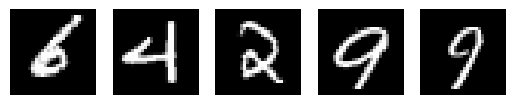

1/1 [==============================] - 0s 48ms/step


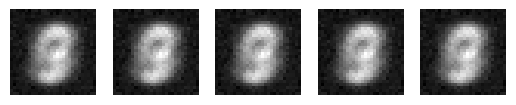

In [6]:
original = X_test[random_test_indices]
mnist_utils.plot_images(original, image_size=image_size, cmap='gray')

model.evaluate(X_train, X_train)
model.evaluate(X_test, X_test)
restored = model.predict(original)
mnist_utils.plot_images(restored, image_size=image_size, cmap='gray')